In [2]:
import pandas as pd
#import pandas_profiling as pp
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score as r2
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [2]:
## Preprocessing

In [3]:
graph = pd.read_csv(r'Graphene/Graphene_BMD_UPDATED_no_outliers.csv')
graph.rename(columns={'variable':'assay'}, inplace=True)

graph.func.fillna('', inplace=True)
# Combine the graphene type name and the functionalization in a unique feature called new_name
graph['new_name'] = graph.Substance + ' ' + graph.func
graph.loc[graph.layer ==0.0, 'layer'] = np.nan
# Data set for viability endpoints - df_v
viability_list = ['nucleo', 'alive','cfa', 'viability_alamar', 'ez_cyto', 'viability_pi',
       'viability_ldh', 'viability_mtt',  'viability_cck', 'viability_wst', 'neutral_red', 'viability_hymolisis']
graph = graph.loc[graph['assay'].isin(viability_list), :].copy()

# NEW Replace viability_x for x
graph['assay'] = graph['assay'].apply(lambda row: row.replace('viability_', ''))

# keep only alpha numeric characters in media column
graph['media'] = graph['media'].apply(lambda row: re.sub(r'\W+', '', row))
df_v = graph.copy() 
## REMOVE OUTLIERS - The outliers were found via IBM SPSS
df_v = df_v[df_v['BMDL'] < 296.425]
df_v.reset_index(drop=True, inplace=True)
df_v.dropna(subset=['layer'], inplace=True)
df_v.reset_index(drop=True, inplace=True)

In [3]:
df_v.head()

,analysis,BMD,BMDL,BMDH,bmd_id,ID,author_year,link,Substance,type,...,ali,time,cell_type,cell_type_general,species,endotox,assay,new_name,BMD_range,cell_species
0,Graphene_4070_dose_viability_pi.txt,59.93000,51.8000,68.400,4070,358,Mittal et all 2016,https://www.nature.com/articles/srep39548,Graphene oxide,GO,...,Submerged,24,A549,epithelial,human,NO,pi,Graphene oxide,16.6000,epithelial_human
1,Graphene_1018_dose_alive.txt,38.56000,23.3000,58.300,1018,111,Ma et al 2015,https://pubmed.ncbi.nlm.nih.gov/26389709/,Graphene oxide,GO Sheets long,...,Submerged,24,J774.A1,macrophage,rodent,NaN,alive,Graphene oxide,35.0000,macrophage_rodent
2,Graphene_2013_dose_cfa.txt,0.08387,0.0799,0.088,2013,95,Chaterje N 2015,https://pubmed.ncbi.nlm.nih.gov/26602558/,Graphene,GNPs,...,Submerged,240,BEAS- 2B,epithelial,human,NaN,cfa,Graphene,0.0081,epithelial_human
3,Graphene_2014_dose_cfa.txt,10.00000,9.8000,10.200,2014,101,Chaterje N 2015,https://pubmed.ncbi.nlm.nih.gov/26602558/,Graphene oxide,GO Single layer,...,Submerged,240,BEAS- 2B,epithelial,human,NaN,cfa,Graphene oxide,0.4000,epithelial_human
4,Graphene_2015_dose_cfa.txt,0.55740,0.5260,0.589,2015,102,Chaterje N 2015,https://pubmed.ncbi.nlm.nih.gov/26602558/,Graphene oxide,GO few layers,...,Submerged,240,BEAS- 2B,epithelial,human,NaN,cfa,Graphene oxide,0.0630,epithelial_human


In [4]:
len(df_v)

74

In [5]:
df_analysis = df_v[['bmd_id', 'Substance', 'func', 'media', 'size_class', 'layer', 'time', 'cell_type_general', 'species', 'assay', 'BMDL']].copy()

In [7]:
#Data Visualization

In [6]:
#eda = pp.ProfileReport(df_analysis)
#display(eda)
df_analysis.describe()

,bmd_id,layer,time,BMDL
count,74.000000,74.000000,74.000000,74.000000
mean,5293.175676,2.398649,41.513514,60.043455
std,1789.030520,1.947917,56.058981,70.022873
min,1018.000000,1.000000,3.000000,0.070800
25%,4097.500000,1.000000,24.000000,10.575000
50%,6070.500000,1.500000,24.000000,28.600000
75%,6090.750000,3.500000,48.000000,80.825000
max,9057.000000,8.000000,240.000000,264.000000


In [9]:
### Preprocessing: Eliminate the ones with less than elements

In [7]:
filter_df = pd.DataFrame()
elements = 3 #Select sets with more than 3 elements
for column in ['media', 'assay']:
    print(df_analysis.groupby(by=column, as_index=False).agg({'bmd_id': pd.Series.nunique}).sort_values(by='bmd_id', ascending=False))
    a_df = df_analysis.groupby(by=column, as_index=False).agg({'bmd_id': pd.Series.nunique}).sort_values(by='bmd_id', ascending=False)
    columns = a_df[a_df['bmd_id']>elements][column].values
    if len(filter_df)==0:
        filter_df = df_analysis[df_analysis.apply(lambda row: row[column] in columns, axis=1)]
    else:
        filter_df = filter_df[filter_df.apply(lambda row: row[column] in columns, axis=1)]
data_df = filter_df.copy()

                  media  bmd_id
8             RPMI10FBS      22
3          DMEMF1210FBS      18
6              F1210FBS      14
1             DMEM10FBS       7
0             BEGM10FBS       4
4       DMEMF12and10FBS       2
7                  RPMI       2
10             RPMI2FBS       2
2               DMEMF12       1
5   DMEMORRPMIplus10FBS       1
9             RPMI10FCS       1
         assay  bmd_id
5          mtt      36
4          ldh      10
7           pi       8
2          cfa       5
3      ez_cyto       5
8          wst       5
1          cck       2
6  neutral_red       2
0        alive       1


In [8]:
data_df.describe()

,bmd_id,layer,time,BMDL
count,61.000000,61.000000,61.000000,61.000000
mean,5337.836066,2.491803,44.459016,61.252389
std,1524.042346,1.948272,61.294800,69.955486
min,2013.000000,1.000000,3.000000,0.070800
25%,5003.000000,1.000000,24.000000,9.800000
50%,6071.000000,1.500000,24.000000,31.100000
75%,6087.000000,3.500000,48.000000,122.000000
max,8039.000000,8.000000,240.000000,231.000000


In [ ]:
## Select only the columns you want to include

In [9]:
data_df.columns

Index(['bmd_id', 'Substance', 'func', 'media', 'size_class', 'layer', 'time',
       'cell_type_general', 'species', 'assay', 'BMDL'],
      dtype='object')

In [9]:
columns = ['Substance', 'func','media', 'size_class', 'layer', 'time','cell_type_general', 'species', 'assay','BMDL']
data_df = data_df[columns]
data_df.head()

,Substance,func,media,size_class,layer,time,cell_type_general,species,assay,BMDL
0,Graphene oxide,,DMEMF1210FBS,S,1.0,24,epithelial,human,pi,51.8000
2,Graphene,,F1210FBS,L,2.0,240,epithelial,human,cfa,0.0799
3,Graphene oxide,,F1210FBS,M,1.0,240,epithelial,human,cfa,9.8000
4,Graphene oxide,,F1210FBS,M,6.0,240,epithelial,human,cfa,0.5260
5,Graphene,NH2,F1210FBS,L,1.5,240,epithelial,human,cfa,0.2240


In [17]:
## Encoding

In [10]:
enc_size = {'S':1, 'M':2, 'L':3}
col_continuous = ['layer', 'time'] 
dataset_df = pd.get_dummies(data_df[['Substance', 'func', 'cell_type_general','assay', 'media', 'species']], prefix=['Substance', 'func', 'cell_type_general','assay', 'media', 'species'])
dataset_df['size_class'] = data_df['size_class'].apply(lambda row: enc_size[row])
dataset_df[col_continuous] = data_df[col_continuous]
dataset_df['BMDL'] = data_df['BMDL']
dataset_df.head()

,Substance_Graphene,Substance_Graphene oxide,Substance_rGO,func_,func_COOH,func_NH2,func_PAA,func_PAM,func_PEG,func_hydrated,...,media_DMEM10FBS,media_DMEMF1210FBS,media_F1210FBS,media_RPMI10FBS,species_human,species_rodent,size_class,layer,time,BMDL
0,0,1,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,1,1.0,24,51.8000
2,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,3,2.0,240,0.0799
3,0,1,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,2,1.0,240,9.8000
4,0,1,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,2,6.0,240,0.5260
5,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,3,1.5,240,0.2240


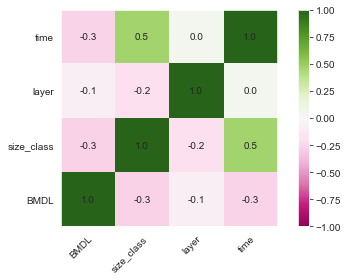

In [11]:
#Correlation matrix
corr_rf = dataset_df[['BMDL', 'size_class', 'layer', 'time']]


corr_matrix = corr_rf.corr()
fig = plt.figure()
ax = plt.subplot()
im = ax.imshow(corr_matrix, cmap=plt.cm.PiYG, interpolation='nearest', vmin=-1, vmax=1)
tick_marks = [i for i in range(len(corr_matrix.columns))]
tick_names = ['BMDL', 'size_class', 'layer', 'time']
ax.set_xticks(tick_marks)
ax.set_xticklabels(tick_names)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor", fontsize=10)
ax.set_yticks(tick_marks)
ax.set_yticklabels(tick_names)
plt.setp(ax.get_yticklabels(), fontsize=10)
ax.set_ylim(-0.5, 3.5)
for (i, j), z in np.ndenumerate(corr_matrix):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
fig.colorbar(im, ax=ax)
ax.grid(None)
plt.tight_layout()
plt.savefig('Graphene//New_plots//graphene_correlation_matrix_BMDL_no outliers.pdf', dpi=400)
plt.show()


In [ ]:
##Normalize the data

In [12]:
scaler = MinMaxScaler()
dataset_df[col_continuous+['size_class']] = scaler.fit_transform(dataset_df[col_continuous+['size_class']])
dataset_df[col_continuous+['size_class']].head()

,layer,time,size_class
0,0.000000,0.088608,0.0
2,0.142857,1.000000,1.0
3,0.000000,1.000000,0.5
4,0.714286,1.000000,0.5
5,0.071429,1.000000,1.0


In [21]:
## Create model

In [13]:
x_columns = [col for col in dataset_df.columns if col != 'BMDL']
y_columns = ['BMDL']

In [15]:
x_columns

['Substance_Graphene',
 'Substance_Graphene oxide',
 'Substance_rGO',
 'func_',
 'func_COOH',
 'func_NH2',
 'func_PAA',
 'func_PAM',
 'func_PEG',
 'func_hydrated',
 'cell_type_general_epithelial',
 'cell_type_general_macrophage',
 'assay_cfa',
 'assay_ez_cyto',
 'assay_ldh',
 'assay_mtt',
 'assay_pi',
 'assay_wst',
 'media_BEGM10FBS',
 'media_DMEM10FBS',
 'media_DMEMF1210FBS',
 'media_F1210FBS',
 'media_RPMI10FBS',
 'species_human',
 'species_rodent',
 'size_class',
 'layer',
 'time']

In [24]:
# create matrix

In [14]:
X =  dataset_df[x_columns].values
y =  dataset_df[y_columns].values.ravel()

In [15]:
dataset_df[x_columns]

,Substance_Graphene,Substance_Graphene oxide,Substance_rGO,func_,func_COOH,func_NH2,func_PAA,func_PAM,func_PEG,func_hydrated,...,media_BEGM10FBS,media_DMEM10FBS,media_DMEMF1210FBS,media_F1210FBS,media_RPMI10FBS,species_human,species_rodent,size_class,layer,time
0,0,1,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0.0,0.000000,0.088608
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1.0,0.142857,1.000000
3,0,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0.5,0.000000,1.000000
4,0,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0.5,0.714286,1.000000
5,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,1.0,0.071429,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0.0,0.071429,0.189873
65,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0.5,0.000000,0.012658
66,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0.5,0.000000,0.012658
67,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0.5,0.000000,0.012658


In [18]:
y


array([5.18e+01, 7.99e-02, 9.80e+00, 5.26e-01, 2.24e-01, 1.95e+00,
       2.76e+01, 5.24e+01, 4.98e+01, 2.20e+01, 1.11e+01, 1.30e+02,
       3.11e+01, 5.20e+01, 2.12e+02, 1.48e+01, 1.97e+00, 2.30e+01,
       2.31e+01, 3.12e+01, 5.71e+01, 3.15e+01, 1.48e+02, 1.10e-01,
       1.41e-01, 1.61e+01, 1.21e+01, 4.11e+01, 1.04e+01, 4.18e+00,
       5.87e-01, 1.73e+02, 1.37e+02, 5.30e+01, 8.35e+00, 1.96e+00,
       8.07e-01, 7.08e-02, 1.24e+02, 2.73e+01, 6.06e+00, 2.18e+00,
       1.82e+02, 1.95e+02, 1.50e+02, 4.75e+01, 1.87e+02, 2.31e+02,
       2.03e+02, 7.28e+01, 1.24e+02, 4.31e+01, 1.57e+01, 1.82e+02,
       2.14e+02, 1.22e+02, 6.37e+01, 4.35e+01, 2.68e+01, 1.85e+01,
       1.33e+01])

In [111]:
## Linear regression OLS

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     2.015
Date:                Tue, 03 May 2022   Prob (F-statistic):             0.0287
Time:                        16:53:32   Log-Likelihood:                -322.76
No. Observations:                  61   AIC:                             689.5
Df Residuals:                      39   BIC:                             736.0
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
constant        

In [16]:
# LINEAR REGRESSION

# NEW LOOCV
cv = LeaveOneOut()
cv2 = RepeatedKFold(n_splits=5, n_repeats=1, random_state=3)
# create model
model = LinearRegression()
# OLD evaluation model
scores = cross_val_score(model, X, y, scoring='r2', cv=cv2)
print('5Fold crossval R2: %f (%f)' % (np.mean(scores), np.std(scores)))
print(scores)
# NEW EVALUATION OF MODEL
# evaluate model fitting
model.fit(X, y)
fitting = model.score(X, y, sample_weight=None)
print(f'Model fitting R2: {fitting}')
# evaluate model
y_pred = cross_val_predict(model, X, y, cv=cv)
r2_score = round(r2(y,y_pred),3)
#Calculate Root Mean Square Error
rms = round(mean_squared_error(y, y_pred, squared=False),2)
# report performance
print(f'LOOCV R2: {r2_score}')
# report performance
print(f'LOOCV RMSE: {rms}')


# Or with Mean Square Error as metric
scoring = "neg_mean_squared_error"
results = cross_val_score(model, X, y, cv=cv, scoring=scoring)
print(); print("Mean Squared Error: ", results.mean()); print("Standard Deviation: ", results.std())



5Fold crossval R2: -0.126362 (0.231670)
[ 0.15439712 -0.18521562 -0.06208042 -0.00395436 -0.53495593]
Model fitting R2: 0.5203988402244784
LOOCV R2: 0.259
LOOCV RMSE: 59.73

Mean Squared Error:  -3568.16981131671
Standard Deviation:  5317.465872917963


In [28]:
## BayesianRidge

In [17]:
# prepare the cross-validation procedure
# NEW LOOCV
cv = LeaveOneOut()
cv2 = RepeatedKFold(n_splits=5, n_repeats=1, random_state=3)
# create model
model = BayesianRidge()
# OLD evaluation model
scores = cross_val_score(model, X, y, scoring='r2', cv=cv2)
print('5Fold crossval R2: %f (%f)' % (np.mean(scores), np.std(scores)))
print(scores)
# NEW EVALUATION OF MODEL
# evaluate model fitting
model.fit(X, y)
fitting = model.score(X, y, sample_weight=None)
print(f'Model fitting R2: {fitting}')
# evaluate model
y_pred = cross_val_predict(model, X, y, cv=cv)
r2_score = round(r2(y,y_pred),3)
#Calculate Root Mean Square Error
rms = round(mean_squared_error(y, y_pred, squared=False),2)
# report performance
print(f'LOOCV R2: {r2_score}')
# report performance
print(f'LOOCV RMSE: {rms}')


# Or with Mean Square Error as metric
scoring = "neg_mean_squared_error"
results = cross_val_score(model, X, y, cv=cv, scoring=scoring)
print(); print("Mean Squared Error: ", results.mean()); print("Standard Deviation: ", results.std())

5Fold crossval R2: 0.152428 (0.262834)
[ 0.2693016   0.3607382   0.39064915  0.06163697 -0.32018451]
Model fitting R2: 0.3631134867118305
LOOCV R2: 0.204
LOOCV RMSE: 61.88

Mean Squared Error:  -3829.7007567412224
Standard Deviation:  5029.257555674806


In [21]:
scores

array([ 0.2693016 ,  0.3607382 ,  0.39064915,  0.06163697, -0.32018451])

In [31]:
## Multi-layer Perceptron regressor.
## solver: The solver for weight optimization.‘lbfgs’ is an optimizer in the family of quasi-Newton methods.
## alpha: L2 penalty (regularization term) parameter.
## hidden_layer_sizes: The ith element represents the number of neurons in the ith hidden layer.

In [18]:
# prepare the cross-validation procedure
cv2 = RepeatedKFold(n_splits=5, n_repeats=1, random_state=3)
# NEW LOOCV
cv = LeaveOneOut()
# create model 
model = MLPRegressor(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(5, 2), random_state=1, max_iter=1000000)
# OLD evaluation model
scores = cross_val_score(model, X, y, scoring='r2', cv=cv2)
print('5Fold crossval R2: %f (%f)' % (np.mean(scores), np.std(scores)))
print(scores)
# NEW EVALUATION OF MODEL
# evaluate model fitting
model.fit(X, y)
fitting = model.score(X, y, sample_weight=None)
print(f'Model fitting R2: {fitting}')
# evaluate model
y_pred = cross_val_predict(model, X, y, cv=cv)
r2_score = round(r2(y,y_pred),3)
#Calculate Root Mean Square Error
rms = round(mean_squared_error(y, y_pred, squared=False),2)
# report performance
print(f'LOOCV R2: {r2_score}')
# report performance
print(f'LOOCV RMSE: {rms}')


# Or with Mean Square Error as metric
scoring = "neg_mean_squared_error"
results = cross_val_score(model, X, y, cv=cv, scoring=scoring)
print(); print("Mean Squared Error: ", results.mean()); print("Standard Deviation: ", results.std())

C:\Users\daina\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


5Fold crossval R2: -0.277469 (0.685068)
[ 0.1396752   0.69279626 -0.12556406 -1.15516743 -0.93908696]
Model fitting R2: 0.5572999020906528
LOOCV R2: 0.087
LOOCV RMSE: 66.28

Mean Squared Error:  -4393.333332916641
Standard Deviation:  6871.979387929096


In [23]:
scores

array([ 0.1351592 ,  0.69256713, -0.12800706, -1.14617191, -0.92728303])

In [57]:
##GradientBoostingRegressor

231.0

In [19]:
# prepare the cross-validation procedure
cv2 = RepeatedKFold(n_splits=5, n_repeats=1, random_state=3)
cv = LeaveOneOut()
# create model
model = GradientBoostingRegressor(random_state=0)
# OLD evaluation model
scores = cross_val_score(model, X, y, scoring='r2', cv=cv2)
print('5Fold crossval R2: %f (%f)' % (np.mean(scores), np.std(scores)))
print(scores)
# NEW EVALUATION OF MODEL
# evaluate model fitting
model.fit(X, y)
fitting = model.score(X, y, sample_weight=None)
print(f'Model fitting R2: {fitting}')
# evaluate model
y_pred = cross_val_predict(model, X, y, cv=cv)
r2_score = round(r2(y,y_pred),3)
#Calculate Root Mean Square Error
rms = round(mean_squared_error(y, y_pred, squared=False),2)
# report performance
print(f'LOOCV R2: {r2_score}')
# report performance
print(f'LOOCV RMSE: {rms}')


# Or with Mean Square Error as metric
scoring = "neg_mean_squared_error"
results = cross_val_score(model, X, y, cv=cv, scoring=scoring)
print(); print("Mean Squared Error: ", results.mean()); print("Standard Deviation: ", results.std())

5Fold crossval R2: -0.449847 (0.516638)
[-0.24316703  0.43883453 -0.60184188 -0.79108974 -1.05196973]
Model fitting R2: 0.5746384339865007
LOOCV R2: -0.17
LOOCV RMSE: 75.04

Mean Squared Error:  -5631.683596717837
Standard Deviation:  9240.595289474455


In [36]:
## Random Forest

In [20]:
# prepare the cross-validation procedure
cv2 = RepeatedKFold(n_splits=5, n_repeats=1, random_state=3)
cv = LeaveOneOut()
# create model
model = RandomForestRegressor(random_state=1)
# OLD evaluation model
scores = cross_val_score(model, X, y, scoring='r2', cv=cv2)
print('5Fold crossval R2: %f (%f)' % (np.mean(scores), np.std(scores)))
print(scores)
# NEW EVALUATION OF MODEL
# evaluate model fitting
model.fit(X, y)
fitting = model.score(X, y, sample_weight=None)
print(f'Model fitting R2: {fitting}')
# evaluate model
y_pred = cross_val_predict(model, X, y, cv=cv)
r2_score = round(r2(y,y_pred),3)
#Calculate Root Mean Square Error
rms = round(mean_squared_error(y, y_pred, squared=False),2)
# report performance
print(f'LOOCV R2: {r2_score}')
# report performance
print(f'LOOCV RMSE: {rms}')


# Or with Mean Square Error as metric
scoring = "neg_mean_squared_error"
results = cross_val_score(model, X, y, cv=cv, scoring=scoring)
print(); print("Mean Squared Error: ", results.mean()); print("Standard Deviation: ", results.std())

5Fold crossval R2: -0.324534 (0.487462)
[-0.0643667   0.36779689 -0.33418133 -0.48250731 -1.10941403]
Model fitting R2: 0.5656008176878732
LOOCV R2: -0.284
LOOCV RMSE: 78.61

Mean Squared Error:  -6178.9759677663305
Standard Deviation:  9643.378093641755


In [38]:
### XGBoost

In [21]:
# prepare the cross-validation procedure
cv2 = RepeatedKFold(n_splits=5, n_repeats=1, random_state=3)
cv = LeaveOneOut()
# create model
model = XGBRegressor()
# evaluate model
# OLD evaluation model
scores = cross_val_score(model, X, y,  cv=cv2)
print('5Fold crossval R2: %f (%f)' % (np.mean(scores), np.std(scores)))
print(scores)
# NEW EVALUATION OF MODEL
# evaluate model fitting
model.fit(X, y)
fitting = model.score(X, y, sample_weight=None)
print(f'Model fitting R2: {fitting}')
# evaluate model
y_pred = cross_val_predict(model, X, y, cv=cv)
r2_score = round(r2(y,y_pred),3)
#Calculate Root Mean Square Error
rms = round(mean_squared_error(y, y_pred, squared=False),2)
# report performance
print(f'LOOCV R2: {r2_score}')
# report performance
print(f'LOOCV RMSE: {rms}')


# Or with Mean Square Error as metric
scoring = "neg_mean_squared_error"
results = cross_val_score(model, X, y, cv=cv, scoring=scoring)
print(); print("Mean Squared Error: ", results.mean()); print("Standard Deviation: ", results.std())

5Fold crossval R2: -0.867931 (0.500118)
[-0.70048194  0.01884872 -1.20199831 -1.04737985 -1.40864366]
Model fitting R2: 0.5934357725979253
LOOCV R2: -0.766
LOOCV RMSE: 92.2

Mean Squared Error:  -8500.987929735466
Standard Deviation:  14227.486641710988


In [ ]:
scores

In [22]:
# prepare the cross-validation procedure
cv2 = RepeatedKFold(n_splits=5, n_repeats=1, random_state=3)
cv = LeaveOneOut()
# create model
#reg1 = GradientBoostingRegressor(random_state=1)
reg2 = BayesianRidge()
reg3 = MLPRegressor(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(5, 2), random_state=1, max_iter=1000)
#reg4 = XGBRegressor()
model = VotingRegressor(estimators=[('br', reg2), ('mlpr',reg3)])

# OLD evaluation model
scores = cross_val_score(model, X, y, scoring='r2', cv=cv2)
print('5Fold crossval R2: %f (%f)' % (np.mean(scores), np.std(scores)))
print(scores)
# NEW EVALUATION OF MODEL
# evaluate model fitting
model.fit(X, y)
fitting = model.score(X, y, sample_weight=None)
print(f'Model fitting R2: {fitting}')
# evaluate model
y_pred = cross_val_predict(model, X, y, cv=cv)
r2_score = round(r2(y,y_pred),3)
#Calculate Root Mean Square Error
rms = round(mean_squared_error(y, y_pred, squared=False),2)
# report performance
print(f'LOOCV R2: {r2_score}')
# report performance
print(f'LOOCV RMSE: {rms}')


# Or with Mean Square Error as metric
scoring = "neg_mean_squared_error"
results = cross_val_score(model, X, y, cv=cv, scoring=scoring)
print(); print("Mean Squared Error: ", results.mean()); print("Standard Deviation: ", results.std())


C:\Users\daina\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


5Fold crossval R2: 0.017004 (0.429374)
[ 0.25161216  0.58573224  0.19628921 -0.35513963 -0.59347275]
Model fitting R2: 0.5136953093581766


C:\Users\daina\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\daina\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\daina\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

LOOCV R2: 0.216
LOOCV RMSE: 61.45


C:\Users\daina\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\daina\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\daina\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE


Mean Squared Error:  -3775.575935294816
Standard Deviation:  5564.765615101471


In [ ]:
scores